In [1]:
import numpy as np
from qiskit.opflow import StateFn, PauliExpectation, Zero, One,Z,X,I,PauliOp,ListOp, AerPauliExpectation,DictStateFn,MatrixOp,PrimitiveOp, MatrixExpectation,ComposedOp
from qiskit.circuit.library import TwoLocal,EfficientSU2,UGate
from qiskit.opflow.state_fns import CircuitStateFn
from qiskit.opflow.converters import CircuitSampler
from qiskit import Aer
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.test.mock import FakeMontreal
from qiskit.providers.aer.noise import NoiseModel

import qiskit
print(qiskit.__version__)

from qiskit.providers.aer.library import SaveExpectationValueVariance

from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms import VQE
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit.quantum_info.operators import Operator
from qiskit.circuit import Parameter
from qiskit.providers.aer import AerSimulator,QasmSimulator


from random import random,seed
from math import pi
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

from scipy.optimize import curve_fit

#my functions
from enhanced_sampling import EnhancedSampling

# import EnhancedSampling


def is_unitary(m):
    return np.allclose(np.eye(m.shape[0]), m.H * m)

0.18.2


In [2]:
def update_dict(old_dict, sampler, num_qubits):
    new_dict = old_dict.copy()
    events = sampler.oplist[1].execution_results['counts'].items()
    for key,item in events:
        binary_value = bin(int(key,16))[2:].zfill(num_qubits)
        if binary_value not in new_dict.keys():
            new_dict[binary_value]=item
        else:
            new_dict[binary_value]+=item 
    return new_dict
def get_amplitudes(old_dict,num_shot):
    new_dict = {}
    for key,item in old_dict.items():
            new_dict[key]= np.sqrt(item/num_shot)
    return new_dict
def get_RMSE(results, true_value):
    return np.sqrt(sum([(mu-true_value)**2 for mu in results.values()])/len(results))

In [3]:
#Declare an Hamiltonian

H_first_part = Z ^ Z ^ Z
H_second_part = (X ^ I ^ I) + (I ^ X ^ I)

#Hamiltonian =  (Z ^ Z) +(X ^ I) + (I ^ X)

Hamiltonian =  H_first_part + H_second_part 

print(Hamiltonian)

1.0 * ZZZ
+ 1.0 * XII
+ 1.0 * IXI


# Build circuits

We need an ansatz circuit, and operators to measure on it.
Here we first build the ansatz from EfficientSU(2), define a set of random angles to apply to it.
Then we create the simple circuit containing the anstaz and the operators to measure (the Hamiltonian parts)
After that, we combine the anstaz with layers of the enhance circuit using fixed x_angles on these layers (=pi/2) to use Chebyshev-like functions, so we can take multiple samples of the same circuit, instead of modifying after each shot(this would means using ELF)

In [4]:
# Define global variables
num_qubit = Hamiltonian.num_qubits
Layers = 3  #Layers of enhanced circuit

fixed_x_angles = np.ones(2*Layers)*np.pi/2 # list of pi/2 ,to use CLF insteaf of ELF

useNoise = False

num_preshots=4000

num_postshot=2000

repetitions = 1
sample_every = 1000

steps_pre = max(1,round(num_preshots/sample_every))
steps = max(1,round(num_postshot/sample_every))

n_points = 10000 #to use for binning

In [5]:
seed(44) #44 ok #1 wtf?
# Ansatz creation
ansz = EfficientSU2(num_qubit,['ry','rz'],reps=1)
angles_set = {}
param = ansz.ordered_parameters
for j in range(len(param)):
    angles_set[param[j]]= random()*2*pi
ansz_assigned = ansz.bind_parameters(angles_set)

print(' Random angles assigned to ansatz',angles_set)


 Random angles assigned to ansatz {ParameterVectorElement(θ[0]): 2.5669066339875286, ParameterVectorElement(θ[1]): 3.4053105645086, ParameterVectorElement(θ[2]): 5.416335802913373, ParameterVectorElement(θ[3]): 1.1100229798922292, ParameterVectorElement(θ[4]): 1.414718991468211, ParameterVectorElement(θ[5]): 0.1828234342134787, ParameterVectorElement(θ[6]): 0.7329369178028627, ParameterVectorElement(θ[7]): 0.05532737919413898, ParameterVectorElement(θ[8]): 0.9845144111728377, ParameterVectorElement(θ[9]): 3.227755283768095, ParameterVectorElement(θ[10]): 6.2171673160425955, ParameterVectorElement(θ[11]): 4.357453485004286}


In [6]:
test = EnhancedSampling.EnhancedSampler(Hamiltonian,
                                        Layers,
                                        ansz_assigned)

num qubits 3


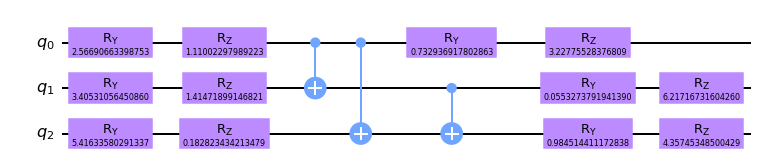

In [7]:
test._ansatz.decompose().draw(output='mpl',filename='EfficientSU2')

In [8]:
#Backend and Quantum instance
backend=Aer.get_backend('qasm_simulator')
#simulator = Aer.get_backend('aer_simulator')
backend_sv = Aer.get_backend('statevector_simulator')



device_backend = FakeMontreal()
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)



if useNoise == False: 
    noise_model = None
    coupling_map = None

# SET UP INITIAL SAMPLING 
q_instance_pre = QuantumInstance(backend=backend,
                             shots=sample_every, #to adapt
                             skip_qobj_validation = False,
                             coupling_map=coupling_map,
                             noise_model=noise_model)

q_instance_post = QuantumInstance(backend=backend,
                                    shots=sample_every,
                                    skip_qobj_validation = False,
                                    coupling_map=coupling_map,
                                    noise_model=noise_model)
print('Number of preshots',num_preshots)
print('Number of postshots',num_postshot)

Number of preshots 4000
Number of postshots 2000


In [9]:
def compute_variance(exp_op, sfdict):
    def sum_variance(operator,sfdict):
        if isinstance(operator, ComposedOp):
            #sfdict = operator.oplist[1]
            measurement = operator.oplist[0]
            average = measurement.eval(sfdict)
            variance = sum(
                (v * (measurement.eval(b) - average)) ** 2
                for (b, v) in sfdict.items()
            )
            return operator.coeff * variance

        elif isinstance(operator, ListOp):
            return operator.combo_fn([sum_variance(op) for op in operator.oplist])

        return 0.0

    return sum_variance(exp_op,sfdict)

## Phase 1: Initial pre-sampling (frequentist mode)

In [10]:
def make_simple_circuit(ansatz,P):
    ansz_state = CircuitStateFn(primitive=ansatz)
    complete_circuit = StateFn(P, is_measurement=True).compose(ansz_state) #simple circuit to sample Hamiltonian on ansatz
    expectation = PauliExpectation().convert(complete_circuit) 
    exact_exp = AerPauliExpectation().convert(complete_circuit)
    return expectation,exact_exp

In [11]:
#FREQ
pre_energy_freq = {}
std_dev_freq = {}
variance_freq = {}
freq_dict = {}
exact_energy = {}
exact_expectation ={}
expectation = {}


for H_part in Hamiltonian.to_pauli_op():
    print(H_part)
    primitive = str(H_part)
    freq_dict[primitive] = {}
    variance_freq[primitive] = {}
    std_dev_freq[primitive] = {}
    pre_energy_freq[primitive] = {}

    expectation[primitive], exact_expectation= make_simple_circuit(ansz_assigned,H_part)
    for step in range(steps_pre):
        variance_freq[primitive][step] = {}
        std_dev_freq[primitive][step] = {}
        pre_energy_freq[primitive][step] = {}
        for rep in range(repetitions):
            sampler = CircuitSampler(backend=q_instance_pre , attach_results=True).convert(expectation[primitive])
            
            #
            operator_in_use = sampler.oplist[0]
            
            
            if rep not in freq_dict[primitive].keys(): freq_dict[primitive][rep] = {}
            freq_dict[primitive][rep] = update_dict(freq_dict[primitive][rep], sampler, num_qubit)
            ampli_dict = get_amplitudes(freq_dict[primitive][rep],(step+1)*sample_every)
            variance_freq[primitive][step][rep] = np.real(compute_variance(sampler,ampli_dict)/(num_preshots-1))
            std_dev_freq[primitive][step][rep] = np.sqrt(variance_freq[primitive][step][rep])
            # pre_energy_freq[primitive][step][rep] = sampler.eval().real
            pre_energy_freq[primitive][step][rep] = operator_in_use.eval(ampli_dict).real
            #print(operator_in_use.eval(ampli_dict).real,freq_dict[primitive][rep])
        #print(freq_dict)
        # update dictionary of events
        # for key,item in sampler.oplist[1].execution_results['counts'].items():
        #     binary_value = bin(int(key,16))[2:].zfill(num_qubit)
        #     freq_dict[primitive][binary_value]=item
        #     print('\t outcome:',binary_value,', counts:',item)


    #EXACT
    sampler_exact = CircuitSampler(backend_sv).convert(exact_expectation)
    exact_energy[primitive] = sampler_exact.eval().real
    print( 'Exact',exact_energy[primitive])



print('\nExact: Energy=', sum(exact_energy.values()))


#print('Frequ: Energy=',[pre_energy_freq[k].values() for k in pre_energy_freq.keys()])#,', Variance', sum(variance_freq.values()), 'Standard Deviation',sum(std_dev_freq.values()))


ZZZ
Exact -0.10785594226944892
XII
Exact 0.4504792175806916
IXI
Exact 0.06428637695352224

Exact: Energy= 0.40690965226476494


In [12]:

post_energy_freq = {}

for H_part in Hamiltonian.to_pauli_op():
    
    primitive = str(H_part)
    print('\n',primitive,'freq event presampling \n',freq_dict[primitive][0] ,pre_energy_freq[primitive][steps_pre-1][0])
    post_energy_freq[primitive] = {}
    #FREQ: combine pre and post sampling

    for step in range(steps):
        post_energy_freq[primitive][step] = {}
        
        for rep in range(repetitions):
            sampler_2 = CircuitSampler(backend=q_instance_post, attach_results=True).convert(expectation[primitive])
            freq_dict[primitive][rep] = update_dict(freq_dict[primitive][rep], sampler_2,num_qubit)
            operator_in_use = sampler_2.oplist[0]
            ampli_dict = get_amplitudes(freq_dict[primitive][rep],num_preshots+((step+1)*sample_every))
            post_energy_freq[primitive][step][rep] = operator_in_use.eval(ampli_dict).real
        #print(freq_dict[primitive][0])
    # post_energy_freq[primitive] /= repetitions

    print('Exact energy =',exact_energy[primitive])
    print('Frequentist pre+post: energy',primitive,post_energy_freq[primitive][steps-1][0], '\n \tevents', freq_dict[primitive][0])



 ZZZ freq event presampling 
 {'001': 1916, '101': 1181, '010': 108, '111': 19, '011': 150, '000': 350, '110': 99, '100': 177} -0.10999999999999992
Exact energy = -0.10785594226944892
Frequentist pre+post: energy ZZZ -0.10333333333333336 
 	events {'001': 2864, '101': 1782, '010': 157, '111': 28, '011': 229, '000': 539, '110': 140, '100': 261}

 XII freq event presampling 
 {'101': 829, '001': 2194, '111': 74, '011': 101, '000': 396, '010': 199, '100': 150, '110': 57} 0.44499999999999995
Exact energy = 0.4504792175806916
Frequentist pre+post: energy XII 0.44533333333333325 
 	events {'101': 1251, '001': 3309, '111': 127, '011': 149, '000': 608, '010': 270, '100': 206, '110': 80}

 IXI freq event presampling 
 {'010': 293, '111': 468, '000': 185, '011': 899, '101': 669, '001': 1214, '110': 170, '100': 102} 0.08499999999999995
Exact energy = 0.06428637695352224
Frequentist pre+post: energy IXI 0.08066666666666669 
 	events {'010': 464, '111': 690, '000': 259, '011': 1345, '101': 1006, '

## Phase 2: Enhanced sampling vs Frequentist

In [13]:


print( '\nRepetition',repetitions)
fit_energy,fit_variance = test.eval(pre_energy_freq,std_dev_freq,q_instance_post,repetitions ,steps, steps_pre)

freq_tot_energy = 0
enha_tot_energy = 0
for H_part in Hamiltonian.to_pauli_op():
    print()
    primitive = str(H_part)
    print(primitive)
    print('Exact energy =',exact_energy[primitive])
    print('Initial energy=',sum(pre_energy_freq[primitive][steps_pre-1].values())/repetitions,'err=',sum(std_dev_freq[primitive][steps_pre-1].values())/repetitions)
        
    #print('Theta values=',test_in_use._initial_theta,' np.arcos(E)',np.arccos(pre_energy_freq[primitive]), 'Energy',pre_energy_freq[primitive])
    
    print('Frequentist energy',sum(post_energy_freq[primitive][steps-1].values())/repetitions)
    print('Enhanced Energy =',sum(fit_energy[primitive][steps-1].values())/repetitions, 'err=',np.sqrt(sum(fit_variance[primitive][steps-1].values())/repetitions))
        
    freq_tot_energy += sum(post_energy_freq[primitive][steps-1].values())/repetitions
    enha_tot_energy += sum(fit_energy[primitive][steps-1].values())/repetitions
    
print('\nTotal Frequentis energy',freq_tot_energy,
            '\nTotal Enahnced energy', enha_tot_energy) 
print('\nTotal Exact energy', sum(exact_energy.values()))


Repetition 1


Sampling for ZZZ ...
Initial prior bounds: [4718, 5982]
Time pre-sampling: 9.297266244888306
Outcomes {0: 835, 1: 165}


 NEW FIT
Outcomes: {0: 835, 1: 165}
Guesses: amp, mean and std_dev: 0.028889837040618385 1.676031005258493 0.00433576704071709
FIT SUCCESS: Converged with popt: [0.02890348 1.67605882 0.00433695]
Outcomes {0: 1680, 1: 320}


 NEW FIT
Outcomes: {0: 1680, 1: 320}
Guesses: amp, mean and std_dev: 0.04005495822947471 1.677722693235963 0.0031287221244362833
FIT SUCCESS: Converged with popt: [0.04005808 1.67773803 0.00312918]
Time sampling: 0.8476636409759521


Sampling for XII ...
Initial prior bounds: [2899, 4163]
Time pre-sampling: 8.372225761413574
Outcomes {0: 565, 1: 435}


 NEW FIT
Outcomes: {0: 565, 1: 435}
Guesses: amp, mean and std_dev: 0.028851034102340547 1.103847239464032 0.0043427005953010425
FIT SUCCESS: Converged with popt: [0.02885848 1.10384344 0.00434363]
Outcomes {0: 1114, 1: 886}


 NEW FIT
Outcomes: {0: 1114, 1: 886}
Guesses: amp, mean 

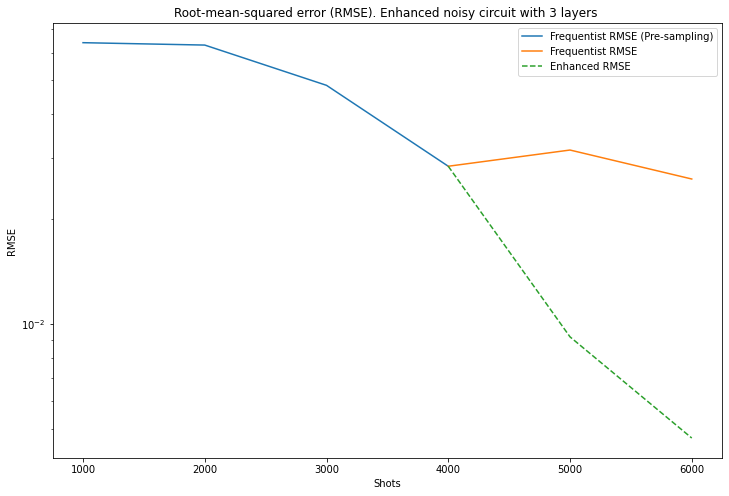

In [14]:
lenH = len(Hamiltonian.to_pauli_op())
freq_rmse = np.zeros((lenH,steps+1))
enha_rmse = np.zeros((lenH,steps+1))
pre_freq_rmse = np.zeros((lenH,steps_pre))
plt.figure(figsize=(12,8))
for h,H_part in enumerate(Hamiltonian.to_pauli_op()):
    primitive = str(H_part)
    for t in range(steps_pre):
        pre_freq_rmse[h,t] = get_RMSE(pre_energy_freq[primitive][t],exact_energy[primitive])
    freq_rmse[h,0]= pre_freq_rmse[h,steps_pre-1]
    enha_rmse[h,0]= pre_freq_rmse[h,steps_pre-1]
    for t in range(0,steps):
        #print(pre_energy_freq[primitive][t])
        freq_rmse[h,t+1] = get_RMSE(post_energy_freq[primitive][t],exact_energy[primitive])
        enha_rmse[h,t+1] = get_RMSE(fit_energy[primitive][t],exact_energy[primitive])
plt.plot(np.asarray(range(1,steps_pre+1))*sample_every, 
         np.sum(pre_freq_rmse,axis=0), label="Frequentist RMSE (Pre-sampling)" )
plt.plot(num_preshots+np.asarray(range(steps+1))*sample_every, np.sum(freq_rmse,axis=0) , label="Frequentist RMSE")
plt.plot(num_preshots+np.asarray(range(steps+1))*sample_every, np.sum(enha_rmse,axis=0) ,linestyle = '--', label="Enhanced RMSE")
#plt.plot(range(num_steps),-0.01+1/np.sqrt(range(1000,1000+num_steps)))
plt.yscale('log')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Shots')
plt.title('Root-mean-squared error (RMSE). Enhanced noisy circuit with '+str(Layers)+' layers ')
plt.savefig('RMSE_'+str(Layers)+'__rep'+str(repetitions)+'noisytest.png')